In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
import torch
import torch.nn as nn
import torch.optim as optim
warnings.filterwarnings('ignore')

train_path = '/content/drive/MyDrive/ColabProjects/dataset/train'
test_path = '/content/drive/MyDrive/ColabProjects/dataset/validation'

In [5]:
# Create an instance of ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use a fraction of images for validation
)

# Create an instance of ImageDataGenerator for validation and test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use training subset
    shuffle=True,
    seed=42
)

# Create a generator for validation data
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use validation subset
    shuffle=True,
    seed=42
)

# Create a generator for test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Example usage: Get a batch of images and labels
images, labels = next(train_generator)
print(images.shape, labels.shape)

Found 141 images belonging to 5 classes.
Found 35 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
(32, 331, 331, 3) (32, 5)


In [14]:

# Create the model
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(331, 331, 3)
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Change this to 5 to match the number of classes
])


In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [19]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [20]:
# Calculate steps
batch_size = 32
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=25,
    callbacks=[early]
)

Epoch 1/25
4/4 [==============================] - 171s 40s/step - loss: 1.4608 - accuracy: 0.3578 - val_loss: 1.0916 - val_accuracy: 0.5312
Epoch 2/25
4/4 [==============================] - 133s 35s/step - loss: 0.9961 - accuracy: 0.5780 - val_loss: 0.7631 - val_accuracy: 0.7188
Epoch 3/25
4/4 [==============================] - 113s 29s/step - loss: 0.8527 - accuracy: 0.6972 - val_loss: 0.7912 - val_accuracy: 0.6562
Epoch 4/25
4/4 [==============================] - 127s 33s/step - loss: 0.6514 - accuracy: 0.7064 - val_loss: 0.7743 - val_accuracy: 0.7188
Epoch 5/25
4/4 [==============================] - 111s 28s/step - loss: 0.5698 - accuracy: 0.7523 - val_loss: 0.9821 - val_accuracy: 0.6250
Epoch 6/25
4/4 [==============================] - 125s 37s/step - loss: 0.4574 - accuracy: 0.8257 - val_loss: 0.7036 - val_accuracy: 0.6562
Epoch 7/25
4/4 [==============================] - 113s 28s/step - loss: 0.4724 - accuracy: 0.8257 - val_loss: 0.8048 - val_accuracy: 0.7500
Epoch 8/25
4/4 [====

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.save('/content/drive/MyDrive/ColabProjects/carmodel.keras')

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9266055226325989\nValidation Accuracy: 0.71875')

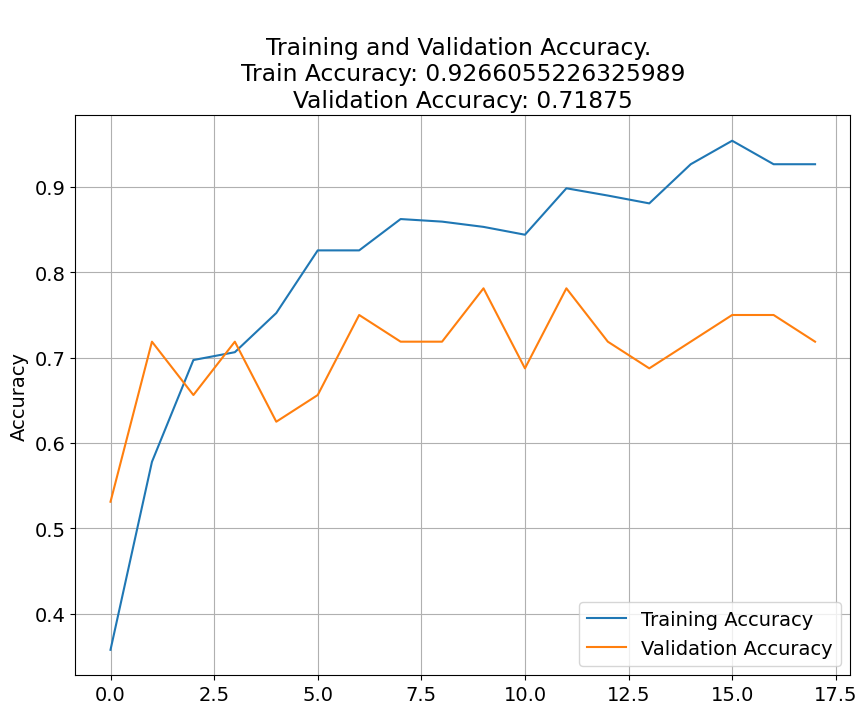

In [22]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('\nTraining and Validation Accuracy. \nTrain Accuracy: '
          + str(acc[-1]) + '\nValidation Accuracy: ' + str(val_acc[-1]))

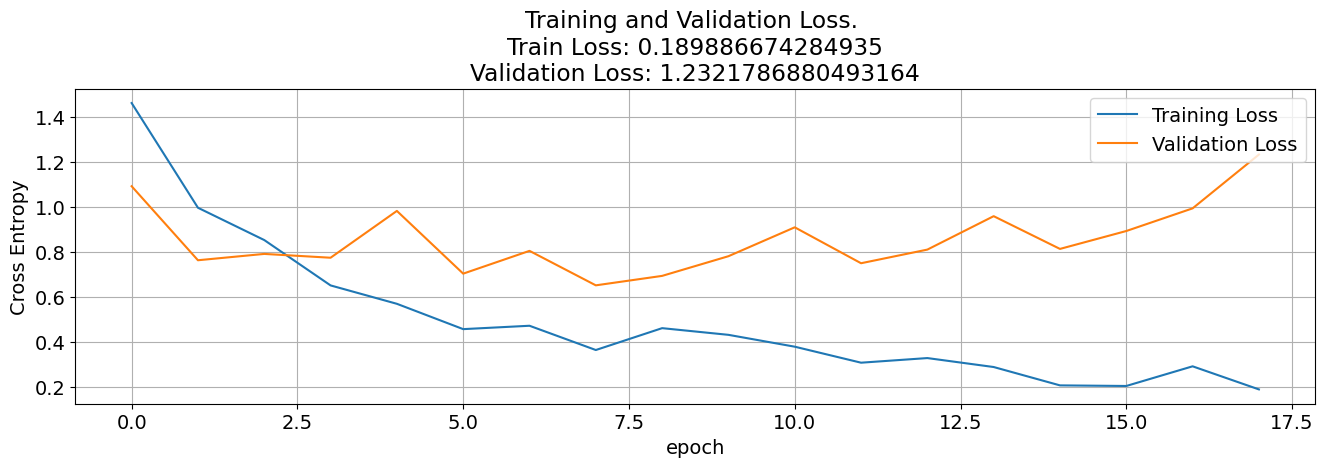

<Figure size 1600x900 with 0 Axes>

In [23]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.show()
plt.tight_layout(pad=3.0)
plt.show()

In [24]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

2/2 [==============================] - 37s 5s/step - loss: 0.6881 - accuracy: 0.7429
[0.6880817413330078, 0.7428571581840515]
Accuracy: 74.2857%
Loss:  0.6880817413330078


In [36]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import tensorflow as tf
import os
from PIL import Image
from torchvision import transforms
import torch

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the required input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your model
model = keras.models.load_model('/content/drive/MyDrive/ColabProjects/carmodel.keras')
model.summary()  # Print model summary to ensure it's loaded correctly

def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = torch.tensor(image.numpy())
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

app = Flask(__name__)

@app.route('/')
def index():
    return render_template_string('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Image Classification</title>
        </head>
        <body>
            <h1>Upload an Image for Classification</h1>
            <form action="/predict" method="post" enctype="multipart/form-data">
                <input type="file" name="file">
                <input type="submit" value="Upload">
            </form>
        </body>
        </html>
    ''')

@app.route('/predict', methods=['POST'])
def upload_file():
    if request.method == 'POST':
        file = request.files['file']
        if file:
            image_path = os.path.join('uploads', file.filename)
            file.save(image_path)
            prediction = predict(image_path)
            return render_template_string('''
                <!DOCTYPE html>
                <html lang="en">
                <head>
                    <meta charset="UTF-8">
                    <meta name="viewport" content="width=device-width, initial-scale=1.0">
                    <title>What Type of Car is This?</title>
                </head>
                <body>
                    <h1>Prediction Result</h1>
                    <img src="/static/uploads/{{ image_filename }}" alt="Uploaded Image" style="max-width: 400px;">
                    <h2>Prediction: {{ prediction }}</h2>
                    <a href="/">Go Back</a>
                </body>
                </html>
            ''', prediction=prediction, image_filename=file.filename)
    return None

if not os.path.exists('uploads'):
    os.makedirs('uploads')

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f' * Tunnel URL: {public_url}')

# Run the app
app.run(port=5000)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

ERROR:pyngrok.process.ngrok:t=2024-06-28T06:35:05+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-06-28T06:35:05+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.